## From-Scratch “MiniTorch” — Notebook Overview

In this notebook we will **implement a minimal deep-learning framework from scratch** (“miniTorch”) and use it to train a simple neural network on the **MNIST** dataset as a toy problem.

### Objectives
- **Layers:** Implement core layers (e.g., `Linear`, `Dropout`, `BatchNorm1D`) with clean APIs.
- **Forward & Backward:** Write explicit **forward** and **backward** passes for every layer (no autograd).
- **Losses:** Implement a **cross-entropy from logits** loss.
- **Training Loop:** Build an epoch-based loop with **train/validation** splits and metrics.
- **Optimization:** Perform **manual SGD** parameter updates (learning rate, gradient averaging, etc.).

### Scope & Assumptions
- We will **not** use PyTorch autograd; gradients are computed **manually**.
- Tensors are used only as numerical containers and for basic ops (matmul, sum, etc.).
- We adopt PyTorch-style `net.train()` / `net.eval()` mode switches for realism.
- The dataset is **MNIST** (28×28 grayscale digits, 10 classes), serving as a **toy setting** to validate our implementation.

### What You’ll Get By the End
- A working “miniTorch” stack: layers → forward/backward → training loop → optimizer.
- Clear, student-friendly code that mirrors real libraries while remaining small and inspectable.



## 1. Loading the MNIST Dataset

We will use the **MNIST** dataset — a classic benchmark of **28×28 grayscale images** of handwritten digits (0–9).  
It contains:
- **60,000** training images
- **10,000** test images

### Steps:
1. **Download & Transform**  
   - Use `torchvision.datasets.MNIST` to automatically download the data.
   - Convert images to tensors and normalize pixel values to the range \([-1, 1]\).

2. **Split into Train & Validation**  
   - The official training set (60,000 samples) will be split into:
     - **Training set:** 80% of the data (48,000 images).
     - **Validation set:** 20% of the data (12,000 images).
   - The split allows us to monitor generalization during training.

3. **Test Set**  
   - The test set (10,000 images) is kept separate and **only used at the end** to report final performance.

### Why Split into Validation?
The validation set helps track **overfitting**:  
- If training accuracy keeps increasing but validation accuracy stalls or decreases, the model is memorizing instead of generalizing.

### Summary
- **Training set:** update model weights.
- **Validation set:** tune hyperparameters & monitor generalization.
- **Test set:** final unbiased evaluation.


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# pick the seed for reproducibility - change it to explore the effects of random variations
np.random.seed(0)
import random
from tqdm import tqdm
from torch.utils.data import random_split

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

In [10]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load full train dataset
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split into train and validation
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

# Test data
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [11]:
# Example: Iterate over a few batches
for images, labels in trainloader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


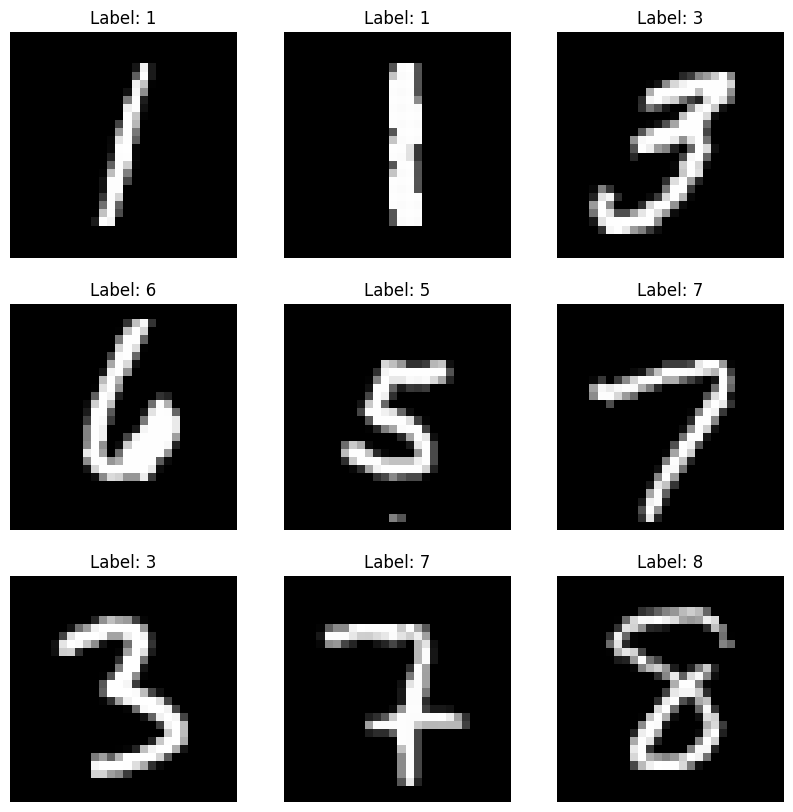

In [12]:
# Check some examples
for images, labels in trainloader:
    # Denormalize the images for plotting
    images = images * 0.5 + 0.5

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')  # images[i][0] for grayscale images
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break


## 2. Implementing the Linear Layer

The **Linear** (or fully connected / dense) layer is one of the fundamental building blocks of neural networks.  
It performs a **linear transformation** of the input:

$$
Z = XW + b
$$

- **Forward pass:**  
  Takes the input $X \in \mathbb{R}^{\text{batch} \times n_{\text{in}}}$ and computes the weighted sum using the weight matrix $W \in \mathbb{R}^{n_{\text{in}} \times n_{\text{out}}}$ and bias vector $b \in \mathbb{R}^{n_{\text{out}}}$.
- **Backward pass:**  
  Computes the gradients of the loss with respect to $W$, $b$, and $X$ so we can update the parameters during training.
- **Update step:**  
  Applies a gradient descent step to $W$ and $b$ using the computed gradients and a learning rate.

Below is a template where you will fill in the missing pieces (`# TODO`) to implement forward, backward, and update logic.

In [13]:
class Linear:
    """
    A simple fully connected (dense) layer.
    Performs a linear transformation:  Z = XW + b
    """

    def __init__(self, nin, nout, device="cpu"):
        """
        Initialize the layer parameters.
        """
        # Initialize weights from a normal distribution
        self.W = torch.randn(nin, nout, device=device, requires_grad=False)
        # Initialize biases to zero
        self.b = torch.zeros(nout, device=device, requires_grad=False)
        self.training = True  # for compatibility with Dropout/BatchNorm

    def train(self):
        """Switch to training mode."""
        self.training = True
        return self

    def eval(self):
        """Switch to evaluation mode."""
        self.training = False
        return self

    def forward(self, X):
        """
        Forward pass: compute the output of the layer.
        """
        self.X = X  # store for backward pass
        # TODO: Implement Z = XW + b
        Z = torch.matmul(X, self.W) + self.b
        return Z

    def backward(self, dZ):
        """
        Backward pass: compute gradients w.r.t. W, b, and X.
        """
        # TODO: Compute self.dW, self.db, and self.dX
        batch_size = self.X.size(0)
        self.dW = torch.matmul(self.X.T, dZ) / batch_size
        self.db = torch.sum(dZ, dim=0) / batch_size
        self.dX = torch.matmul(dZ, self.W.T)
        return self.dX

    def update(self, lr):
        """
        Update parameters using gradient descent.
        """
        # TODO: Update W and b using self.dW and self.db
        self.W -= lr * self.dW
        self.b -= lr * self.db

# Example usage
nin = 4
nout = 3
n_batch = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Simulated input tensor
X = torch.randn(n_batch, nin).to(device)

# Create an instance of the Linear class and compute the linear transformation
net = Linear(nin, nout, device=device)
Z = net.forward(X)
print(Z.shape)

torch.Size([5, 3])


## 3. CrossEntropyFromLogits Loss

To train a neural network for **classification**, we need a loss function that measures how well the predicted class scores (logits) match the true labels.  
A very common choice is the **Cross-Entropy Loss**, combined with the **Softmax** function.

### Step 1: Softmax

Given the logits for each sample:
$$
Z \in \mathbb{R}^{m \times C}
$$
where $m$ is the batch size and $C$ is the number of classes,  
the softmax function converts logits into probabilities:

$$
A_{i,j} = \frac{\exp(Z_{i,j})}{\sum_{k=1}^{C} \exp(Z_{i,k})}
$$

This ensures:
- $A_{i,j} \geq 0$ (all outputs are non-negative)
- $\sum_{j=1}^{C} A_{i,j} = 1$ (rows sum to 1, valid probability distribution).

### Step 2: Cross-Entropy Loss

If $Y_i$ is the true label for sample $i$ (an integer in $[0, C-1]$),  
the cross-entropy loss for one sample is:

$$
\ell_i = -\log\big( A_{i, Y_i} \big)
$$

The loss over the batch is the average:

$$
\mathcal{L} = \frac{1}{m} \sum_{i=1}^m \ell_i
= -\frac{1}{m} \sum_{i=1}^m \log\big( A_{i, Y_i} \big)
$$

### Step 3: Gradient (Backward Pass)

The derivative of the loss with respect to the logits is elegant:

$$
\frac{\partial \mathcal{L}}{\partial Z_{i,j}}
= A_{i,j} - \mathbf{1}[j = Y_i]
$$

That is:
- For the correct class: $A_{i,Y_i} - 1$
- For other classes: $A_{i,j}$

This makes backpropagation very efficient.

---

### Summary

- **Forward pass:** compute softmax + cross-entropy.  
- **Backward pass:** subtract 1 from the probability of the true class.  

This loss is standard for multi-class classification problems such as MNIST.

---

We can express this more compactly in **matrix form**.

Let:
- $ A \in \mathbb{R}^{m \times C} $ be the matrix of softmax outputs,  
- $ Y \in \mathbb{R}^{m \times C} $ be the one-hot encoded true labels,  
- $ m $ = batch size.  

Then the gradient of the loss w.r.t. the logits $Z$ is:

$$
\frac{\partial \mathcal{L}}{\partial Z} = \frac{1}{m}\,(A - Y)
$$

---

### Key Points:
- The subtraction $$ A - Y $$ automatically applies the correct rule to all classes in all samples.
- The factor $ \tfrac{1}{m} $ appears if the loss is averaged across the batch (omit it if summing).
- This compact vectorized form makes backpropagation efficient in practice.

In [19]:
class CrossEntropyFromLogits:
    """
    Implements the combination of:
    - Softmax activation (from raw logits)
    - Cross-entropy loss

    This is a common choice for multi-class classification.
    """

    def forward(self, Z, Y):
        """
        Forward pass: compute the cross-entropy loss from raw logits.

        Args:
            Z (torch.Tensor): Logits (unnormalized scores) of shape (batch_size, n_classes).
            Y (torch.Tensor): True class indices of shape (batch_size,).

        Returns:
            loss torch.Tensor: Scalar value of the cross-entropy loss.
        """
        self.Y = Y  # Store true labels for backward pass

        # TODO: Compute softmax probabilities (convert logits to probabilities)
        # self.A = ...
        Z_shifted = Z - torch.max(Z, dim=1, keepdim=True)[0]
        exp_Z = torch.exp(Z_shifted)
        sum_exp_Z = torch.sum(exp_Z, dim=1, keepdim=True)
        self.A = exp_Z / sum_exp_Z

        # TODO: Compute log-softmax (log probabilities)
        # log_softmax_Z = ...
        log_sum_exp = torch.log(sum_exp_Z)
        log_softmax_Z = Z_shifted - log_sum_exp

        # TODO: Select the log-probabilities of the correct classes for each sample
        # log_probs = ...
        log_probs = log_softmax_Z[range(len(Y)), Y]

        # TODO: Cross-entropy loss: average negative log-likelihood
        # loss = ...
        loss = -torch.mean(log_probs)

        return loss

    def backward(self, n_classes):
        """
        Backward pass: compute the gradient of the loss with respect to logits Z.

        Args:
            n_classes (int): Number of classes in the classification problem.

        Returns:
            torch.Tensor: Gradient dZ of shape (batch_size, n_classes).
        """
        batch_size = len(self.Y)
        # TODO: One-hot encode the true labels
        # Y_one_hot = ...
        # Y_one_hot = torch.zeros_like(self.A) # Alternativa
        Y_one_hot = torch.zeros(batch_size, n_classes)
        Y_one_hot[range(batch_size), self.Y] = 1

        # TODO: Derivative of cross-entropy w.r.t logits: softmax_output - one_hot_labels
        # dZ = ...
        dZ = (self.A - Y_one_hot) / batch_size

        return dZ

# Example usage
CELoss = CrossEntropyFromLogits()
Y = torch.randint(0, 3, (n_batch,))
loss = CELoss.forward(Z, Y)
print(loss)

tensor(1.5628)


## 4. Training Loop — Forward, Backward, Manual Parameter Updates (No Optimizers Yet)

In this section you’ll complete the **core learning cycle** using only the pieces we’ve built:
1. **Forward pass:** compute logits \(Z\) from inputs \(X\).
2. **Loss:** compute cross-entropy from logits and labels.
3. **Backward (loss):** compute \(dZ = \partial \mathcal{L} / \partial Z\) (vectorized).
4. **Backward (network):** backpropagate \(dZ\) through layers to fill per-parameter grads.
5. **Manual update:** call `net.update(learning_rate)` to apply **plain SGD** updates.

### TODOs (what you must fill in)
- [ ] **Forward:** `Z = net.forward(X)`
- [ ] **Loss:** `loss = CELoss.forward(Z, Y)`
- [ ] **Backward (loss):** `dZ = CELoss.backward(n_classes)`  (matrix form \(A - Y\); include \(1/m\) if you average)
- [ ] **Backward (network):** `net.backward(dZ)`
- [ ] **Update:** `net.update(learning_rate)`  *(manual SGD; no optimizer classes yet)*
- [ ] **Metrics:** accumulate running loss/accuracy for train and val

**Tips**
- Average your **layer gradients** by batch size in each layer (e.g., `dW /= m`) for LR stability.
- Keep **validation/test** forward-only (no `backward`, no `update`).
- If you want to tweak LR per epoch, just modify the variable `learning_rate` before the loop or inside it.

In [ ]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
batch_losses = []  # per-batch losses for the plot

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN --------
    if hasattr(net, "train"): net.train()
    running_loss, tot_correct, tot_samples = 0.0, 0, 0
    total_batches = len(trainloader)

    pbar = tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for batch_idx, (images, labels) in enumerate(pbar, 1):
        X = images.view(images.size(0), -1).to(device)
        Y = labels.to(device)

        # Forward
        Z = Z = net.forward(X) #TODO
        loss = CELoss.forward(Z, Y) #TODO

        # Backward + update (manual autograd)
        dZ = CELoss.backward(n_classes)  # TODO
        _ = net.backward(dZ)  # TODO
        net.update(learning_rate)  # TODO



        # Stats
        running_loss += loss.item() #TODO
        batch_losses.append(loss.detach().cpu().item())
        _, predicted = torch.max(Z, 1)
        tot_correct += (predicted == Y).sum().item()
        tot_samples += Y.size(0)

        if batch_idx % max(1, total_batches // 10) == 0:
            pbar.set_postfix(loss=f"{loss.item():.4f}",
                             acc=f"{tot_correct / max(1, tot_samples):.4f}")

    train_loss = running_loss / len(trainloader)  # TODO
    train_acc = tot_correct / tot_samples  # TODO

    # -------- VALIDATION --------
    if hasattr(net, "eval"): net.eval()
    val_running_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)

            Z = net.forward(X)  # TODO
            vloss = CELoss.forward(Z, Y)  # TODO
            val_running_loss += vloss.item()  # TODO

            _, predicted = torch.max(Z, 1)
            val_correct += (predicted == Y).sum().item()
            val_samples += Y.size(0)

    val_loss = val_running_loss / len(valloader)
    val_acc = val_correct / val_samples

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# -------- OPTIONAL TEST --------
if 'testloader' in globals() and testloader is not None:
    if hasattr(net, "eval"): net.eval()
    test_correct, test_samples, test_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="[Test]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)
            Z = net.forward(X) #TODO
            loss = CELoss.forward(Z, Y)#TODO
            test_running_loss += loss.item() #TODO
            _, pred = torch.max(Z, 1)
            test_correct += (pred == Y).sum().item()
            test_samples += Y.size(0)
    test_loss = test_running_loss / len(testloader)
    test_acc = test_correct / test_samples
    print(f"[Test] Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# -------- PLOTS --------
plt.figure(); plt.plot(np.array(batch_losses))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch)'); plt.show()

plt.figure(); plt.plot(history["train_loss"], label='Train'); plt.plot(history["val_loss"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch'); plt.show()

plt.figure(); plt.plot(history["train_acc"], label='Train'); plt.plot(history["val_acc"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch'); plt.show()

## The `Net` Class: A Simple Sequential Container

To organize our neural network, we define a `Net` class that acts as a **sequential container of layers**.  
This class is inspired by frameworks like PyTorch, but implemented from scratch for educational purposes.

### Key Responsibilities

- **Layer Management:**  
  We can add layers (e.g., `Linear`, `ReLU`, `Dropout`) using `add()`.  
  Each layer must implement:
  - `forward()` — computes the output given inputs.  
  - `backward()` — computes the gradients of the loss w.r.t. its inputs.  
  - `update(lr)` — updates the trainable parameters (if any).  

- **Training/Evaluation Modes:**  
  The class has `train()` and `eval()` methods.  
  These switch the whole network into training or evaluation mode, propagating the setting to layers that support it (like `Dropout`, which behaves differently during training vs evaluation).

- **Forward and Backward Passes:**  
  - `forward(X)` runs the input through all layers in sequence.  
  - `backward(dZ)` propagates gradients in reverse order, from the output back to the input.  

- **Parameter Updates:**  
  `update(lr)` applies gradient descent to all trainable layers, using the provided learning rate.  
  (Later we could replace this with more advanced optimizers like Adam or RMSProp.)

### Next Steps

- **TODOs:**  
  - Implement the details of each layer’s `forward()` and `backward()` functions.  
  - Add parameter updates inside `update()` for layers that have weights.  
  - Complete the training loop that uses this `Net` container to build and train a model on MNIST.  

This design provides a clear and modular structure, making it easy to extend with new layers or optimizers.

In [ ]:
class Net:
    """
    A simple sequential container for custom layers.
    Provides PyTorch-like train()/eval() switches and
    runs forward/backward/update across all layers.
    """
 
    def __init__(self):
        """
        Start with an empty list of layers and set the network
        to training mode by default.
        """
        self.layers = []
        self.training = True  # True = training mode, False = eval mode
 
    def add(self, layer):
        """
        Add a layer to the network.
 
        Args:
            layer: Any object that implements forward(), backward(), update(),
                   and (optionally) train()/eval() for mode control.
        """
        self.layers.append(layer)
 
    # ---- Mode control (pro-style) ----
    def train(self):
        """
        Switch the whole network to training mode and propagate
        the setting to layers that implement train().
        """
        self.training = True
        for layer in self.layers:
            if hasattr(layer, "train"):
                layer.train()
        return self
 
    def eval(self):
        """
        Switch the whole network to evaluation mode and propagate
        the setting to layers that implement eval().
        """
        self.training = False
        for layer in self.layers:
            if hasattr(layer, "eval"):
                layer.eval()
        return self
 
    # ---- Core passes ----
    def forward(self, X):
        """
        Forward pass through all layers.
 
        Args:
            X (torch.Tensor): Input to the network.
 
        Returns:
            torch.Tensor: Output after the last layer.
        """
        for layer in self.layers:
            #Implement the forward pass
            X = layer.forward(X)  # TODO  # output of one layer becomes input to the next
        return X
 
    def backward(self, dZ):
        """
        Backward pass through all layers in reverse order.
 
        Args:
            dZ (torch.Tensor): Gradient of the loss w.r.t. network output.
 
        Returns:
            torch.Tensor: Gradient of the loss w.r.t. the network input.
        """
        for layer in reversed(self.layers):
            #Implement the backward pass
            dZ = layer.backward(dZ)  # TODO  # each layer returns grad for the previous one
        return dZ
 
    def update(self, lr):
        """
        Update parameters of all trainable layers with the given learning rate.
 
        Args:
            lr (float): Learning rate.
        """
        for layer in self.layers:
            # Some layers (e.g., activations) may not have parameters
            if hasattr(layer, "update"):
                layer.update(lr)

### Testing the Implementation

The following cells are intended as a **first test** of the network implementation.  
We build a simple architecture with two linear layers and train it using our custom  
cross-entropy loss. Since we have not yet introduced any **non-linear activation functions**,  
this setup is equivalent to a **softmax regression model** (a linear classifier).  

The purpose here is to verify that the forward pass, backward pass, parameter updates,  
and loss tracking are working correctly before moving on to more complex networks.

In [ ]:
# Check if CUDA is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Forcing the device to CPU (this line will override the previous check)
device = 'cpu'

# Define the number of input features and output classes
n_features = 784
n_classes = 10
num_epochs = 2

# Initialize the network (assuming `Net` is a custom class that you've defined)
net = Net()

# Add a linear layer to the network with 784 input features and 1024 output features
net.add(Linear(n_features, 1024, device=device))

# Add another linear layer with 1024 input features and 10 output features
net.add(Linear(1024, n_classes, device=device))

# Initialize the custom cross-entropy loss function from logits
CEloss = CrossEntropyFromLogits()

In [ ]:
# Set the learning rate
learning_rate = 0.001
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
batch_losses = []  # per-batch losses for the plot

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN --------
    if hasattr(net, "train"): net.train()
    running_loss, tot_correct, tot_samples = 0.0, 0, 0
    total_batches = len(trainloader)

    pbar = tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for batch_idx, (images, labels) in enumerate(pbar, 1):
        X = images.view(images.size(0), -1).to(device)
        Y = labels.to(device)

        # Forward
        Z = net.forward(X)
        loss = CELoss.forward(Z, Y)

        # Backward + update (manual autograd)
        dZ = CELoss.backward(n_classes)
        _ = net.backward(dZ)
        net.update(learning_rate)

        # Stats
        running_loss += loss.item()
        batch_losses.append(loss.detach().cpu().item())
        _, predicted = torch.max(Z, 1)
        tot_correct += (predicted == Y).sum().item()
        tot_samples += Y.size(0)

        if batch_idx % max(1, total_batches // 10) == 0:
            pbar.set_postfix(loss=f"{loss.item():.4f}",
                             acc=f"{tot_correct / max(1, tot_samples):.4f}")

    train_loss = running_loss / total_batches
    train_acc = tot_correct / tot_samples

    # -------- VALIDATION --------
    if hasattr(net, "eval"): net.eval()
    val_running_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)

            Z = net.forward(X)
            vloss = CELoss.forward(Z, Y)
            val_running_loss += vloss.item()

            _, predicted = torch.max(Z, 1)
            val_correct += (predicted == Y).sum().item()
            val_samples += Y.size(0)

    val_loss = val_running_loss / len(valloader)
    val_acc = val_correct / val_samples

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# -------- OPTIONAL TEST --------
if 'testloader' in globals() and testloader is not None:
    if hasattr(net, "eval"): net.eval()
    test_correct, test_samples, test_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="[Test]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)
            Z = net.forward(X)
            loss = CELoss.forward(Z, Y)
            test_running_loss += loss.item()
            _, pred = torch.max(Z, 1)
            test_correct += (pred == Y).sum().item()
            test_samples += Y.size(0)
    test_loss = test_running_loss / len(testloader)
    test_acc = test_correct / test_samples
    print(f"[Test] Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# -------- PLOTS --------
plt.figure(); plt.plot(np.array(batch_losses))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch)'); plt.show()

plt.figure(); plt.plot(history["train_loss"], label='Train'); plt.plot(history["val_loss"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch'); plt.show()

plt.figure(); plt.plot(history["train_acc"], label='Train'); plt.plot(history["val_acc"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch'); plt.show()

### ReLU Activation Layer

The **Rectified Linear Unit (ReLU)** is one of the most widely used activation functions in deep learning.  
It introduces **non-linearity** into the network by applying a simple element-wise rule:

$$
a = \text{ReLU}(z) = \max(0, z)
$$

- **Forward Pass**:  
  Each element of the input tensor \( Z \) is mapped to itself if it is positive, or zero if it is negative.  
  This helps prevent the "squashing" effect of sigmoid/tanh and allows gradients to flow more effectively.

- **Backward Pass**:  
  The gradient is passed unchanged for inputs greater than zero and is set to zero for inputs less than or equal to zero:

  $$
  \frac{\partial a}{\partial z} =
  \begin{cases}
  1 & \text{if } z > 0 \\
  0 & \text{if } z \leq 0
  \end{cases}
  $$

- **Update Step**:  
  ReLU has no trainable parameters, so its `update()` method is left empty.

This layer is essential because it allows neural networks to model complex non-linear decision boundaries while remaining computationally efficient.


In [ ]:
class ReLU:
    """
    ReLU activation layer.
    """

    def forward(self, Z):
        """
        Perform the forward pass of the ReLU activation function.

        Args:
            Z (torch.Tensor): Input tensor.

        Returns:
            A torch.Tensor: Output tensor with ReLU applied element-wise.
        """
        self.A = torch.maximum(Z, torch.zeros_like(Z)) #TODO
        return self.A

    def backward(self, dA):
        """
        Perform the backward pass of the ReLU activation function.

        Args:
            dA (torch.Tensor): Gradient of the loss with respect to the output.

        Returns:
            dZ torch.Tensor: Gradient of the loss with respect to the input.
        """
        dZ = dA * (self.A > 0).float() #TODO

        return dZ

    def update(self,lr):
        """
        ReLU does not have any parameters to update.
        """
        pass


In [ ]:
# Check if CUDA is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Forcing the device to CPU (this line will override the previous check)
device = 'cpu'

# Define the number of input features and output classes
n_features = 784
n_classes = 10

# Initialize the network (assuming `Net` is a custom class that you've defined)
net = Net()

# Add a linear layer to the network with 784 input features and 1024 output features
net.add(Linear(n_features, 1024, device=device))

# Add a non-linear activation function
net.add(ReLU())

# Add another linear layer with 1024 input features and 10 output features
net.add(Linear(1024, n_classes, device=device))

# Initialize the custom cross-entropy loss function from logits
CEloss = CrossEntropyFromLogits()

In [ ]:
# Set the learning rate
learning_rate = 0.001
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
batch_losses = []  # per-batch losses for the plot

for epoch in range(1, num_epochs + 1):
    # -------- TRAIN --------
    if hasattr(net, "train"): net.train()
    running_loss, tot_correct, tot_samples = 0.0, 0, 0
    total_batches = len(trainloader)

    pbar = tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for batch_idx, (images, labels) in enumerate(pbar, 1):
        X = images.view(images.size(0), -1).to(device)
        Y = labels.to(device)

        # Forward
        Z = net.forward(X)
        loss = CELoss.forward(Z, Y)

        # Backward + update (manual autograd)
        dZ = CELoss.backward(n_classes)
        _ = net.backward(dZ)
        net.update(learning_rate)

        # Stats
        running_loss += loss.item()
        batch_losses.append(loss.detach().cpu().item())
        _, predicted = torch.max(Z, 1)
        tot_correct += (predicted == Y).sum().item()
        tot_samples += Y.size(0)

        if batch_idx % max(1, total_batches // 10) == 0:
            pbar.set_postfix(loss=f"{loss.item():.4f}",
                             acc=f"{tot_correct / max(1, tot_samples):.4f}")

    train_loss = running_loss / total_batches
    train_acc = tot_correct / tot_samples

    # -------- VALIDATION --------
    if hasattr(net, "eval"): net.eval()
    val_running_loss, val_correct, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)

            Z = net.forward(X)
            vloss = CELoss.forward(Z, Y)
            val_running_loss += vloss.item()

            _, predicted = torch.max(Z, 1)
            val_correct += (predicted == Y).sum().item()
            val_samples += Y.size(0)

    val_loss = val_running_loss / len(valloader)
    val_acc = val_correct / val_samples

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# -------- OPTIONAL TEST --------
if 'testloader' in globals() and testloader is not None:
    if hasattr(net, "eval"): net.eval()
    test_correct, test_samples, test_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="[Test]"):
            X = images.view(images.size(0), -1).to(device)
            Y = labels.to(device)
            Z = net.forward(X)
            loss = CELoss.forward(Z, Y)
            test_running_loss += loss.item()
            _, pred = torch.max(Z, 1)
            test_correct += (pred == Y).sum().item()
            test_samples += Y.size(0)
    test_loss = test_running_loss / len(testloader)
    test_acc = test_correct / test_samples
    print(f"[Test] Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# -------- PLOTS --------
plt.figure(); plt.plot(np.array(batch_losses))
plt.xlabel('Batch'); plt.ylabel('Loss'); plt.title('Training Loss (per batch)'); plt.show()

plt.figure(); plt.plot(history["train_loss"], label='Train'); plt.plot(history["val_loss"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss per Epoch'); plt.show()

plt.figure(); plt.plot(history["train_acc"], label='Train'); plt.plot(history["val_acc"], label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy per Epoch'); plt.show()

### Extending the Neural Network

At this point, we have implemented the essential components of a neural network:  
- **Linear transformations (fully connected layers)** to project data into new spaces,  
- **Non-linear activation functions** such as ReLU to introduce complexity and allow the network to model non-linear relationships, and  
- **A cost function (e.g., Cross-Entropy)** to measure the discrepancy between predictions and true labels.  

While this setup already allows us to train a functional neural network, more advanced operations can significantly improve performance and generalization. Two of the most important techniques are:  

- **Dropout**: Randomly disables a fraction of neurons during training, preventing co-adaptation and reducing overfitting.  
- **Batch Normalization**: Normalizes intermediate activations across a mini-batch, stabilizing training and often accelerating convergence.  

Adding these operations will bring our implementation closer to modern deep learning practices, making the models both more robust and efficient.


### Batch Normalization

Batch Normalization (BN) is used to stabilize and accelerate training by normalizing activations.  
Given input activations $X \in \mathbb{R}^{m \times d}$ (batch size $m$, features $d$):

---

**Training mode**

Batch statistics:  
$$
\mu_{\mathrm{B}}=\frac{1}{m}\sum_{i=1}^m X_i
$$  
$$
\sigma^2_{\mathrm{B}}=\frac{1}{m}\sum_{i=1}^m \left(X_i-\mu_{\mathrm{B}}\right)^2
$$

Normalize, then scale/shift:  
$$
\hat{X}_i=\frac{X_i-\mu_{\mathrm{B}}}{\sqrt{\sigma^2_{\mathrm{B}}+\varepsilon}}
$$  
$$
Y_i=\gamma\,\hat{X}_i+\beta
$$

Update running (EMA) statistics with momentum $\alpha$:  
$$
\mu_{\mathrm{R}} \leftarrow (1-\alpha)\,\mu_{\mathrm{R}} + \alpha\,\mu_{\mathrm{B}}
$$  
$$
\sigma^2_{\mathrm{R}} \leftarrow (1-\alpha)\,\sigma^2_{\mathrm{R}} + \alpha\,\sigma^2_{\mathrm{B}}
$$

---

**Inference mode**

Use stored running statistics (no updates):  
$$
\hat{X}_i=\frac{X_i-\mu_{\mathrm{R}}}{\sqrt{\sigma^2_{\mathrm{R}}+\varepsilon}}
$$  
$$
Y_i=\gamma\,\hat{X}_i+\beta
$$

---

**Summary:**  
- **Training:** use $(\mu_{\mathrm{B}}, \sigma^2_{\mathrm{B}})$, normalize, scale/shift, update $(\mu_{\mathrm{R}}, \sigma^2_{\mathrm{R}})$.  
- **Inference:** use $(\mu_{\mathrm{R}}, \sigma^2_{\mathrm{R}})$ collected during training, normalize, scale/shift, **no updates**.

---

### Task

Implement **BatchNorm as a class** with the following:

- **Forward pass (`forward`)**  
  - #TODO compute batch mean $\mu_{\mathrm{B}}$ and variance $\sigma^2_{\mathrm{B}}$ (training)  
  - #TODO normalize input $X$  
  - #TODO scale and shift using $\gamma, \beta$  
  - #TODO update running mean/variance (training only)  
  - #TODO use running statistics in inference mode  

- **Backward pass (`backward`)**  
  - #TODO compute gradient of loss w.r.t. $\hat{X}$  
  - #TODO propagate through normalization to get $dX$  
  - #TODO compute gradients w.r.t. parameters $\gamma, \beta$  

- **Update parameters (`update`)**  
  - #TODO update $\gamma, \beta$ using the learning rate


In [ ]:
class BatchNorm1D:
    """
    Batch Normalization for 2D inputs: (batch, features).
 
    TRAIN: compute batch stats, normalize, update running stats, support backward().
    EVAL:  use running stats, no updates, typically no backward().
    """
 
    def __init__(self, n_features, eps=1e-5, momentum=0.1, device="cpu"):
        self.eps = eps
        self.momentum = momentum
        self.device = device
 
        # Learnable affine parameters
        self.gamma = torch.ones(n_features, device=device, requires_grad=False)
        self.beta  = torch.zeros(n_features, device=device, requires_grad=False)
 
        # Running (inference) statistics
        self.running_mean = torch.zeros(n_features, device=device, requires_grad=False)
        self.running_var  = torch.ones(n_features,  device=device, requires_grad=False)
 
        # Mode flag
        self.training = True
 
        # Caches for backward
        self.X = None
        self.X_hat = None
        self.batch_mean = None
        self.batch_var = None
        self.std = None
 
        # Grads for parameters
        self.dgamma = None
        self.dbeta  = None
 
    def train(self): self.training = True;  return self
    def eval(self):  self.training = False; return self
 
    def forward(self, X):
        """
        Args:
            X: (batch, features)
        Returns:
            Y: (batch, features)
        """
        if self.training:
            # ===== TODO: compute batch statistics along batch dim =====
            self.batch_mean = torch.mean(X, dim=0)
            self.batch_var = torch.var(X, dim=0, unbiased=False)   # use unbiased=False
            # ===== TODO: compute std and normalized activations =====
            self.std = torch.sqrt(self.batch_var + self.eps)
            self.X_hat = (X - self.batch_mean) / self.std
            #
            # ===== TODO: update running stats (EMA) =====
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * self.batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * self.batch_var
        else:
            # ===== TODO: inference normalization using running stats =====
            self.std = torch.sqrt(self.running_var + self.eps)
            self.X_hat = (X - self.running_mean) / self.std
 
        # Cache input for backward
        self.X = X
 
        # ===== TODO: affine transform Y = gamma * X_hat + beta =====
        Y = self.gamma * self.X_hat + self.beta
        return Y
 
    def backward(self, dY):
        """
        Args:
            dY: upstream gradient (batch, features)
        Returns:
            dX: gradient wrt input X (batch, features)
        """
        if not self.training:
            # In this teaching framework we forbid backward in eval to emphasize the distinction.
            raise RuntimeError("Backward called in eval() mode. Use training mode for gradient computation.")
 
        m = dY.size(0)  # batch size
 
        # ===== TODO: parameter gradients =====
        self.dgamma = torch.sum(dY * self.X_hat, dim=0)
        self.dbeta  = torch.sum(dY, dim=0)
 
        # ===== TODO: gradient wrt normalized activations =====
        dx_hat = dY * self.gamma
 
        # The following hints reflect the standard BN backward derivation:
        x_mu   = self.X - self.batch_mean
        invstd = 1.0 / self.std
        #
        # ===== TODO: compute dvar and dmean using cached tensors =====
        dvar  = torch.sum(dx_hat * x_mu * -0.5 * (invstd ** 3), dim=0)
        dmean = torch.sum(-dx_hat * invstd, dim=0) + dvar * torch.mean(-2.0 * x_mu, dim=0)
        #
        # ===== TODO: put it all together to get dX =====
        dX = dx_hat * invstd + (2.0 / m) * x_mu * dvar + dmean / m
        #
        return dX
        
 
    def update(self, lr):
        """
        Simple SGD update for gamma and beta.
        """
        # ===== TODO: apply SGD step to gamma and beta =====
        self.gamma -= lr * self.dgamma
        self.beta  -= lr * self.dbeta
        


### Inverted Dropout ###

Let:  
$ p = \text{drop probability (fraction of units set to zero in training)}$
$ q = 1-p = \text{keep probability} $
$ X \in \mathbb{R}^{m \times d} = \text{activations (batch } m, \text{ features } d) $
$ M \in \left\{ 0, \frac{1}{q} \right\}^{m \times d} = \text{dropout mask} $

---

**Training mode:**

We sample the mask $$ M $$ as:
$$
M_{ij} =
\begin{cases}
\frac{1}{q}, & \text{with probability } q, \\
0, & \text{with probability } p
\end{cases}
$$

Then the output is:
$$
Y = X \odot M
$$

**Expected value during training:**
$$
\mathbb{E}[Y] = \mathbb{E}[X \odot M] = X \cdot \mathbb{E}[M] = X \cdot \left(q \cdot \frac{1}{q} + p \cdot 0\right) = X
$$

Thus, the expected activations in training match those in inference.

---

**Inference mode:**

No dropout, no scaling:
$$
Y = X
$$

Since training already scaled the kept units by $$ \tfrac{1}{q} $$, the magnitude matches without extra work.

---

**Why not multiply by $ p $?**

Multiplying by $ p $ would shrink the kept activations instead of preserving their expected value:
$$
\mathbb{E}[Y] = X \cdot p \quad \neq \quad X
$$

That would require extra scaling at inference, which *inverted dropout* avoids.

---

**Summary:**

**Training:**  
$$
Y = X \odot M, \quad M_{ij} \in \left\{0, \tfrac{1}{1-p}\right\}
$$

**Inference:**  
$$
Y = X
$$

Property preserved:  
$$
\mathbb{E}[Y] = X
$$

---

### ✅ Task

- Implement an **`Inverted Dropout`** layer with the following methods:  
  - `forward(X)`:  
    - In **training mode**, apply mask $$ M $$ as above.  
    - In **evaluation mode**, return $$ X $$.  
  - `backward(dY)`: propagate gradients through the same mask.  
  - `train()` / `eval()`: toggle between training and inference modes.  
  - `update(lr)`: no parameters to update, but include for API consistency.  

- Verify by simulation that:  
  1. The expected output of the dropout layer in **training** matches the original input.  
  2. No scaling is needed in **evaluation**.


In [ ]:
import torch

class Dropout:
    """
    Inverted Dropout (for fully-connected tensors [batch, features]).

    - TRAIN: randomly zeroes activations with prob p, and rescales by 1/(1-p)
             so the expected activation stays constant.
    - EVAL:  identity (no dropout, no scaling).

    Students must implement the forward and backward passes.
    """

    def __init__(self, p=0.5, device="cpu"):
        """
        Args:
            p (float): Drop probability in [0,1). Typical values: 0.1~0.5
            device (str): 'cpu' or 'cuda'
        """
        assert 0.0 <= p < 1.0, "p must be in [0, 1)."
        self.p = p
        self.device = device
        self.training = True
        self.mask = None  # cache for backward

    # Mode control
    def train(self):
        self.training = True
        return self

    def eval(self):
        self.training = False
        return self

    def forward(self, X):
        """
        Forward pass of dropout.

        Args:
            X: Tensor of shape (batch, features)
        Returns:
            Tensor of same shape
        """
        if self.training and self.p > 0.0:
            # TODO: Implement inverted dropout
            # 1. Compute keep_prob = 1 - p
            # 2. Sample a Bernoulli mask with probability keep_prob
            # 3. Scale the mask by 1 / keep_prob
            # 4. Multiply X by the mask and return
            keep_prob = 1.0 - self.p
            self.mask = (torch.rand_like(X) < keep_prob).float()
            self.mask /= keep_prob  # Scale by 1/keep_prob
            return X * self.mask
        else:
            # TODO: In eval mode, dropout is a no-op
            # Return X unchanged and store a mask of ones for backward
            self.mask = torch.ones_like(X)
            return X

    def backward(self, dY):
        """
        Backward pass of dropout.

        Args:
            dY: Gradient wrt output, shape (batch, features)
        Returns:
            dX: Gradient wrt input, shape (batch, features)
        """
        # TODO: Backprop through dropout
        # TRAIN: dX = dY * mask
        # EVAL:  dX = dY
        return dY * self.mask

    def update(self, lr):
        """
        No learnable parameters in Dropout, so nothing to update.
        Kept for API consistency.
        """
        pass



## Final Task — Put It All Together

In this capstone exercise you will **assemble a complete mini deep-learning stack** and use it to train MNIST models. You’ll integrate **Linear**, **ReLU**, **BatchNorm1D**, and **Dropout**, write a clean **training/validation loop**, experiment with **different architectures**, and finally **package your code** into a reusable Python module.

### What to Build

1. **Model Architectures (experiment)**
   - Start with a baseline: `Linear(784→10)` (softmax regression).
   - Add depth + non-linearities:
     - Example A: `Linear(784→256) → ReLU → Linear(256→10)`
     - Example B: `Linear(784→256) → BatchNorm1D → ReLU → Dropout(p=0.2) → Linear(256→10)`
     - Example C (deeper): `784→512→BatchNorm→ReLU→Dropout→256→BatchNorm→ReLU→Dropout→10`
   - Try **2–3 architectures**. Log train/val loss & accuracy per epoch.

2. **Training Loop (manual updates, no optimizers yet)**
   - Forward → Loss (CrossEntropyFromLogits) → Backward (matrix form) → `net.backward(dZ)` → `net.update(lr)`.
   - Validation after each epoch (no grads, no updates).
   - Record to `history = {"train_loss","train_acc","val_loss","val_acc"}`.
   - Plots: per-batch loss; per-epoch loss/accuracy (train vs. val).

3. **Regularization & Stabilization**
   - **Dropout:** compare `p ∈ {0.0, 0.2, 0.5}`.
   - **BatchNorm:** place BN **before** ReLU in FC blocks (common practice).
   - Optional extras (if time): weight decay (L2), gradient clipping, LR schedule.

4. **Packaging Your Framework**
   - Create a single file **`minitorch.py`** with all components:
     - Layers: `Linear`, `ReLU`, `BatchNorm1D`, `Dropout`
     - Loss: `CrossEntropyFromLogits`
     - Container: `Net`
     - (Optional) utility functions (e.g., accuracy)
   - Import it from your notebook and train.

---

### Deliverables

- **Notebook results:**
  - Table or brief summary of architectures tried, best val accuracy, and comments.
  - Training curves (loss & accuracy) showing the effect of BN/Dropout.
- **`minitorch.py`** file with clean docstrings and minimal dependencies.

---

### Suggested Evaluation Protocol

- Use the same **train/val split** across runs (fix a seed).
- Train for **~5–10 epochs** (enough to see trends).
- Report **best validation accuracy** and final **test accuracy** for your top model.
- Briefly explain **what helped** (BN, Dropout, depth) and **why**.

---

### Checklist / TODOs

- [ ] Implement **forward** and **backward** in `Linear`, `ReLU`, `BatchNorm1D`, `Dropout`.
- [ ] Implement **CrossEntropyFromLogits** with vectorized gradient \(dZ = A - Y\).
- [ ] Write training loop with **manual parameter updates** (`net.update(lr)`).
- [ ] Add **BatchNorm** and **Dropout** in your architectures and compare.
- [ ] Track and plot **history** for train/val.
- [ ] Save best model metrics and briefly **analyze results**.
- [ ] Package everything into **`minitorch.py`** and re-run using imports.

---

### Example `minitorch.py` Skeleton (fill in your implementations)

```python
# minitorch.py
import torch

class Net:
    def __init__(self): self.layers=[]; self.training=True
    def add(self, layer): self.layers.append(layer)
    def train(self): self.training=True; [getattr(l,'train',lambda:None)() for l in self.layers]; return self
    def eval(self):  self.training=False;[getattr(l,'eval', lambda:None)() for l in self.layers]; return self
    def forward(self, X):
        for layer in self.layers: X = layer.forward(X)
        return X
    def backward(self, dZ):
        for layer in reversed(self.layers): dZ = layer.backward(dZ)
        return dZ
    def update(self, lr):
        for layer in self.layers:
            if hasattr(layer, "update"): layer.update(lr)

class Linear:
    # TODO: init (W,b), forward, backward (avg grads), update, parameters (optional)
    ...

class ReLU:
    # TODO: forward (max(0,z)), backward (mask), update (pass)
    ...

class BatchNorm1D:
    # TODO: forward (train/infer paths, EMA), backward (γ, β, dX), update
    ...

class Dropout:
    # TODO: forward (inverted dropout), backward (mask), update (pass)
    ...

class CrossEntropyFromLogits:
    # TODO: forward (softmax/log-softmax + NLL), backward (A - one_hot(Y))
    ...
